In [1]:
from __future__ import print_function, division, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import OrderedDict

# import data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import image utils
from PIL import Image

# import image processing
import scipy.ndimage as ndi
import scipy

# import image utilities
from skimage.morphology import binary_opening, disk, label, binary_closing

# import image augmentation
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform
)

# Import PyTorch
import torch
from torch import nn
from torch import optim
from torch.optim import Optimizer
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from torch.optim import lr_scheduler

import math
import os

import time

from tqdm import tqdm_notebook

Setup the environment:
* paths to folder with data
* load csv with data
* setup the transforms

In [2]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images/'
TEST_PATH = '../input/aptos2019-blindness-detection/test_images/'

train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

train_transforms = Compose([HorizontalFlip(p=0.5),
                            CLAHE(p=1.0),
                            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.2),
                            OneOf([RandomContrast(),
                                   RandomGamma(),
                                   RandomBrightness(),], p=0.3),
                            OneOf([ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                   GridDistortion(),
                                   OpticalDistortion(distort_limit=2, shift_limit=0.5),], p=0.3)])

Seup the dataset:

In [3]:
class AptosDataset(Dataset):
    '''
    The dataset for APTOS data.
    '''
    def __init__(self, dataset_path, df, transforms=None, size = (299, 299), mode = 'train'):
        self.dataset_path = dataset_path
        self.df = df
        self.transforms = transforms
        self.size = size
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # open image and label
        id_code = self.df.loc[idx]['id_code']
        image = Image.open(os.path.join(self.dataset_path, str(id_code) + '.png'))
        
        if self.mode == 'train':
            label = self.df.loc[idx]['diagnosis']
        else:
            label = None
        
        # augment image
        if self.mode == 'train':
            augmented = self.transforms(image=np.array(image))
            image = Image.fromarray(augmented['image'], 'RGB')
        
        # normalize and convert to tensor
        tf = transforms.Compose([transforms.Resize(self.size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.500, 0.500, 0.500], std=[0.500, 0.500, 0.500])])
        image = tf(image)
        
        # in validation mode return image and id_code
        if self.mode == 'validation':
            return image, id_code

        # return tensor with image and label
        return image, label

In [4]:
# weighted kappa metric

from sklearn.metrics import cohen_kappa_score

def kappa_metric(label, pred):
    pred = np.argmax(pred, axis = 1)
    return cohen_kappa_score(label, pred, weights = 'quadratic')

XceptionNet from [pretrained-models.pytorch repo](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/xception.py)

In [5]:
"""
Ported to pytorch thanks to [tstandley](https://github.com/tstandley/Xception-PyTorch)
@author: tstandley
Adapted by cadene
Creates an Xception Model as defined in:
Francois Chollet
Xception: Deep Learning with Depthwise Separable Convolutions
https://arxiv.org/pdf/1610.02357.pdf
This weights ported from the Keras implementation. Achieves the following performance on the validation set:
Loss:0.9173 Prec@1:78.892 Prec@5:94.292
REMEMBER to set your image size to 3x299x299 for both test and validation
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
"""
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

pretrained_settings = {
    'xception': {
        'imagenet': {
            'url': '../input/aptos-preprocessed-data/xception-43020ad28.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000,
            'scale': 0.8975 # The resize parameter of the validation transform should be 333, and make sure to center crop at 299x299
        }
    }
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)

        # #------- init weights --------
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #         m.weight.data.normal_(0, math.sqrt(2. / n))
        #     elif isinstance(m, nn.BatchNorm2d):
        #         m.weight.data.fill_(1)
        #         m.bias.data.zero_()
        # #-----------------------------

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        return x

    def logits(self, features):
        x = nn.ReLU(inplace=True)(features)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def xception(num_classes=1000, pretrained='imagenet'):
    model = Xception(num_classes=num_classes)
    if pretrained:
        settings = pretrained_settings['xception'][pretrained]

        model = Xception(num_classes=num_classes)
        model.load_state_dict(torch.load(settings['url']))

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']
        model.mean = settings['mean']
        model.std = settings['std']

    # TODO: ugly
    model.last_linear = model.fc
    del model.fc
    return model

In [6]:
# initialize pretrained XceptionNet with imagenet weights
xception_model = xception(num_classes=1000, pretrained='imagenet')

In [7]:
# wrap up pretrained XceptionNet with new fc layer
class APTOSXception(nn.Module):

    def __init__(self, xception_model, dropout = 0.3):
        super(APTOSXception, self).__init__()
        self.xception_model = xception_model
        
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(1000, 256)),
            ('relu1', nn.ReLU(inplace=True)),
            ('dropout1', nn.Dropout(dropout)),
            ('fc2', nn.Linear(256, 128)),
            ('bn2', nn.BatchNorm1d(num_features=128)),
            ('relu2', nn.ReLU(inplace=True)),
            ('dropout2', nn.Dropout(dropout)),
            ('fc3', nn.Linear(128, 64)),
            ('bn3', nn.BatchNorm1d(num_features=64)),
            ('relu3', nn.ReLU(inplace=True)),
            ('logits', nn.Linear(64, 5))]))
    
    def forward(self, input):
        x = self.xception_model(input)
        x = nn.ReLU(inplace=True)(x)
        x = self.classifier(x)
        
        return x

In [8]:
# initialize the model
dropout = 0.3
model = APTOSXception(xception_model, dropout = dropout)

In [9]:
# setup training device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [10]:
# define hyperparameters
test_split = 0.2
batch_size = 24
epochs = 20
learning_rate = 0.001

In [11]:
# create dataset and data loaders
train_ds = AptosDataset(TRAIN_PATH, train, transforms=train_transforms, size = (299, 299), mode = 'train')

dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, sampler=test_sampler, num_workers=4)

In [12]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
for param in model.xception_model.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy', 'Kappa train', 'Kappa test']) 

In [13]:
def train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats):
    #train the model
    model.to(device)
    
    # learning rate cosine annealing
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader), eta_min=0.000001)

    steps = 0
    running_loss = 0
    for epoch in range(epochs):

        since = time.time()

        train_accuracy = 0
        top3_train_accuracy = 0 
        kappa_train = 0
        
        for inputs, labels in tqdm_notebook(trainloader):
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # calculate train top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            # Calculate train top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
            
            # Calculate train weighted kappa metric
            kappa_train += kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())

        time_elapsed = time.time() - since

        test_loss = 0
        test_accuracy = 0
        top3_test_accuracy = 0
        kappa_test = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)

                test_loss += batch_loss.item()

                # Calculate test top-1 accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                # Calculate test top-3 accuracy
                np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
                target_numpy = labels.cpu().numpy()
                top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
                
                # Calculate test weighted kappa metric
                kappa_test += kappa_metric(labels.cpu().numpy(), ps.detach().cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Time per epoch: {time_elapsed:.4f}.. "
              f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
              f"Train loss: {running_loss/len(trainloader):.4f}.. "
              f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
              f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
              f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
              f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}"
              f"Weighed kappa test: {kappa_test/len(testloader):.4f}"
              f"Weighed kappa train: {kappa_train/len(trainloader):.4f}")

        train_stats = train_stats.append({'Epoch': epoch + 1, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader), 'Kappa train':kappa_train/len(trainloader), 'Kappa test':kappa_test/len(testloader)}, ignore_index=True)

        running_loss = 0
        model.train()
        scheduler.step()
        
    return model, train_stats

In [14]:
# train the model
model, train_stats = train_model(model, device, trainloader, testloader, epochs, criterion, optimizer, train_stats)


Epoch 1/20.. Time per epoch: 797.3566.. Average time per step: 6.4826.. Train loss: 0.9397.. Train accuracy: 0.6640.. Top-3 train accuracy: 0.8991.. Test loss: 0.8273.. Test accuracy: 0.7110.. Top-3 test accuracy: 0.9409Weighed kappa test: 0.7012Weighed kappa train: 0.6085



Epoch 2/20.. Time per epoch: 827.1674.. Average time per step: 6.7249.. Train loss: 0.7727.. Train accuracy: 0.7158.. Top-3 train accuracy: 0.9485.. Test loss: 0.7128.. Test accuracy: 0.7446.. Top-3 test accuracy: 0.9664Weighed kappa test: 0.7462Weighed kappa train: 0.7089



Epoch 3/20.. Time per epoch: 832.8487.. Average time per step: 6.7711.. Train loss: 0.7587.. Train accuracy: 0.7073.. Top-3 train accuracy: 0.9519.. Test loss: 0.7124.. Test accuracy: 0.7446.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.7688Weighed kappa train: 0.7238



Epoch 4/20.. Time per epoch: 847.7259.. Average time per step: 6.8921.. Train loss: 0.7732.. Train accuracy: 0.7056.. Top-3 train accuracy: 0.9499.. Test loss: 0.7128.. Test accuracy: 0.7312.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.7518Weighed kappa train: 0.7096



Epoch 5/20.. Time per epoch: 840.8206.. Average time per step: 6.8359.. Train loss: 0.8126.. Train accuracy: 0.7026.. Top-3 train accuracy: 0.9465.. Test loss: 0.7050.. Test accuracy: 0.7460.. Top-3 test accuracy: 0.9651Weighed kappa test: 0.7823Weighed kappa train: 0.7091



Epoch 6/20.. Time per epoch: 838.3277.. Average time per step: 6.8157.. Train loss: 0.7441.. Train accuracy: 0.7219.. Top-3 train accuracy: 0.9556.. Test loss: 0.6909.. Test accuracy: 0.7446.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.7366Weighed kappa train: 0.7384



Epoch 7/20.. Time per epoch: 833.0158.. Average time per step: 6.7725.. Train loss: 0.7369.. Train accuracy: 0.7307.. Top-3 train accuracy: 0.9597.. Test loss: 0.7110.. Test accuracy: 0.7218.. Top-3 test accuracy: 0.9704Weighed kappa test: 0.7481Weighed kappa train: 0.7349



Epoch 8/20.. Time per epoch: 864.4795.. Average time per step: 7.0283.. Train loss: 0.7060.. Train accuracy: 0.7304.. Top-3 train accuracy: 0.9600.. Test loss: 0.6838.. Test accuracy: 0.7500.. Top-3 test accuracy: 0.9731Weighed kappa test: 0.7770Weighed kappa train: 0.7603



Epoch 9/20.. Time per epoch: 852.4766.. Average time per step: 6.9307.. Train loss: 0.6910.. Train accuracy: 0.7310.. Top-3 train accuracy: 0.9580.. Test loss: 0.7130.. Test accuracy: 0.7151.. Top-3 test accuracy: 0.9718Weighed kappa test: 0.7365Weighed kappa train: 0.7453



Epoch 10/20.. Time per epoch: 849.2154.. Average time per step: 6.9042.. Train loss: 0.6866.. Train accuracy: 0.7354.. Top-3 train accuracy: 0.9634.. Test loss: 0.6858.. Test accuracy: 0.7473.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.7890Weighed kappa train: 0.7654



Epoch 11/20.. Time per epoch: 827.4246.. Average time per step: 6.7270.. Train loss: 0.6940.. Train accuracy: 0.7344.. Top-3 train accuracy: 0.9651.. Test loss: 0.6995.. Test accuracy: 0.7231.. Top-3 test accuracy: 0.9624Weighed kappa test: 0.7584Weighed kappa train: 0.7495



Epoch 12/20.. Time per epoch: 850.3499.. Average time per step: 6.9134.. Train loss: 0.6735.. Train accuracy: 0.7459.. Top-3 train accuracy: 0.9621.. Test loss: 0.7301.. Test accuracy: 0.7298.. Top-3 test accuracy: 0.9637Weighed kappa test: 0.7581Weighed kappa train: 0.7783



Epoch 13/20.. Time per epoch: 822.3056.. Average time per step: 6.6854.. Train loss: 0.6834.. Train accuracy: 0.7425.. Top-3 train accuracy: 0.9627.. Test loss: 0.6930.. Test accuracy: 0.7446.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.7889Weighed kappa train: 0.7779



Epoch 14/20.. Time per epoch: 834.1409.. Average time per step: 6.7816.. Train loss: 0.6589.. Train accuracy: 0.7530.. Top-3 train accuracy: 0.9675.. Test loss: 0.6740.. Test accuracy: 0.7500.. Top-3 test accuracy: 0.9664Weighed kappa test: 0.7782Weighed kappa train: 0.7804



Epoch 15/20.. Time per epoch: 830.4855.. Average time per step: 6.7519.. Train loss: 0.6528.. Train accuracy: 0.7524.. Top-3 train accuracy: 0.9638.. Test loss: 0.6431.. Test accuracy: 0.7540.. Top-3 test accuracy: 0.9704Weighed kappa test: 0.7969Weighed kappa train: 0.7855



Epoch 16/20.. Time per epoch: 841.8360.. Average time per step: 6.8442.. Train loss: 0.6352.. Train accuracy: 0.7605.. Top-3 train accuracy: 0.9678.. Test loss: 0.7222.. Test accuracy: 0.7272.. Top-3 test accuracy: 0.9731Weighed kappa test: 0.7595Weighed kappa train: 0.7897



Epoch 17/20.. Time per epoch: 845.4437.. Average time per step: 6.8735.. Train loss: 0.6455.. Train accuracy: 0.7490.. Top-3 train accuracy: 0.9705.. Test loss: 0.6906.. Test accuracy: 0.7540.. Top-3 test accuracy: 0.9704Weighed kappa test: 0.7921Weighed kappa train: 0.7763



Epoch 18/20.. Time per epoch: 843.9200.. Average time per step: 6.8611.. Train loss: 0.6494.. Train accuracy: 0.7619.. Top-3 train accuracy: 0.9651.. Test loss: 0.7029.. Test accuracy: 0.7285.. Top-3 test accuracy: 0.9530Weighed kappa test: 0.7656Weighed kappa train: 0.7893



Epoch 19/20.. Time per epoch: 855.5063.. Average time per step: 6.9553.. Train loss: 0.6319.. Train accuracy: 0.7598.. Top-3 train accuracy: 0.9702.. Test loss: 0.6573.. Test accuracy: 0.7567.. Top-3 test accuracy: 0.9691Weighed kappa test: 0.8011Weighed kappa train: 0.8002



Epoch 20/20.. Time per epoch: 712.6789.. Average time per step: 5.7941.. Train loss: 0.6428.. Train accuracy: 0.7588.. Top-3 train accuracy: 0.9631.. Test loss: 0.6608.. Test accuracy: 0.7419.. Top-3 test accuracy: 0.9704Weighed kappa test: 0.8060Weighed kappa train: 0.7849


In [15]:
# view training stats
train_stats.head()

,Epoch,Time per epoch,Avg time per step,Train loss,Train accuracy,Train top-3 accuracy,Test loss,Test accuracy,Test top-3 accuracy,Kappa train,Kappa test
0,1.0,797.356580,6.482574,0.939706,0.663957,0.899051,0.827272,0.711022,0.940860,0.608517,0.701233
1,2.0,827.167416,6.724938,0.772737,0.715786,0.948509,0.712756,0.744624,0.966398,0.708923,0.746234
2,3.0,832.848749,6.771128,0.758701,0.707317,0.951897,0.712380,0.744624,0.969086,0.723827,0.768773
3,4.0,847.725909,6.892081,0.773223,0.705623,0.949864,0.712811,0.731183,0.969086,0.709590,0.751839
4,5.0,840.820597,6.835940,0.812613,0.702575,0.946477,0.704957,0.745968,0.965054,0.709111,0.782250


validate the model:

In [16]:
valid_ds = AptosDataset(TEST_PATH, test, transforms=None, size = (299, 299), mode = 'validation')
validloader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, num_workers=4)

In [17]:
submission = {'id_code': [], 'diagnosis': []}

model.eval()
torch.cuda.empty_cache()

for X, id_codes in tqdm_notebook(validloader):
    X = Variable(X).cuda()
    output = model(X)
    
    for i, id_code in enumerate(id_codes):
        top_p, top_class = output[i].topk(1)
        diagnosis = top_class.cpu().numpy()
        
        submission['id_code'].append(id_code)
        submission['diagnosis'].append(diagnosis[0])

In [18]:
submission_df = pd.DataFrame(submission, columns=['id_code', 'diagnosis'])
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(10)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

,id_code,diagnosis
662,5ab9e78b45ef,2
576,4f985a7320d9,2
1493,c7c003cdaaba,2
346,31d79157e7c4,0
1636,da807f93050c,2
908,7d353a9d3218,2
1656,dd525bbb2ca3,0
878,78bdd1ecee00,0
130,1326dad5651f,0
1498,c85bc4a45f7c,2


In [19]:
diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [20]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(10,20), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(list(diagnosis_dict.values()));
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

    plt.show()

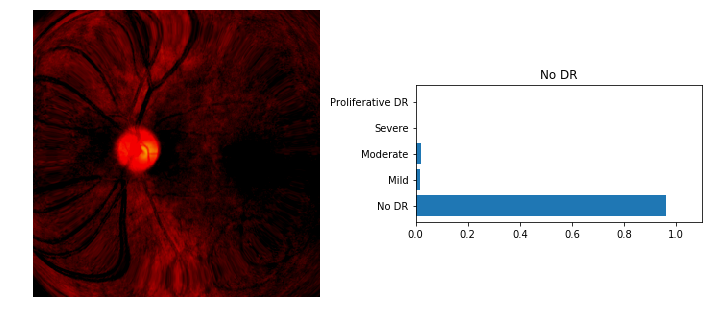

In [21]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), diagnosis_dict[int(label_true.cpu().numpy())])
    
    break;

In [22]:
# save the model

checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, 'Xception.pth')

In [23]:
# save training stats
train_stats.to_csv('Xception_train_stats.csv', index=False)